In [18]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.visualization import plot_histogram
from qiskit import BasicAer

In [80]:
def execute_circuit(circuit, backend=Aer.get_backend('qasm_simulator'), shots=1024):
    job = execute(circuit, backend=backend, shots=shots)
    result = job.result()
    counts = result.get_counts(circuit)
    return counts

def count_to_prob(counts, num_qubits=None):
    shots = sum(counts.values())
    n_qubits = num_qubits if num_qubits is not None else len(list(counts.keys())[0])

    probs = np.zeros(2**n_qubits)
    for key, value in counts.items():
        index = int(key, 2) if type(key) == str else key
        probs[index] = value/shots
    return probs

def get_statevector(circuit, backend=Aer.get_backend('statevector_simulator')):
    job = execute(circuit, backend=backend)
    result = job.result()
    statevector = result.get_statevector(circuit)
    return statevector

def get_unitary(circuit, backend=Aer.get_backend('unitary_simulator')):
    job = execute(circuit, backend=backend)
    result = job.result()
    unitary = result.get_unitary(circuit)
    return unitary

# Setup Qiskit Runtime

In [20]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Sampler, Estimator

In [21]:
QiskitRuntimeService.save_account(channel='ibm_quantum', token='', overwrite=True)

In [22]:
service = QiskitRuntimeService(channel='ibm_quantum')

# Bell Inequality:  CHSH

Let's define the following experiment:

- Alice and Bob share a Bell state 
- Alice and Bob each measure their qubit in one of two bases: $X$ or $Z$
- Alice and Bob repeat this experiment many times

The goal is to show that the correlations between Alice and Bob's measurements cannot be explained by a local hidden variable model.

We will use the CHSH inequality to test this.

$$ S = \langle A_0 B_0 \rangle + \langle A_0 B_1 \rangle + \langle A_1 B_0 \rangle - \langle A_1 B_1 \rangle \leq 2 $$

where $A_0$ is Alice's measurement in the $Z$ basis, $A_1$ is Alice's measurement in the $X$ basis, $B_0$ is Bob's measurement in the $Z$ basis, and $B_1$ is Bob's measurement in the $X$ basis.

## Hidden Variable Model

Let's first define a hidden variable model.

$$ S = a_0 b_0 + a_0 b_1 + a_1 b_0 - a_1 b_1 $$

where $a_0$ and $a_1$ are Alice's hidden variables and $b_0$ and $b_1$ are Bob's hidden variables. Either $a_0$ or $a_1$ can be $\pm 1$, and similarly for $b_0$ and $b_1$. Therefore, it is possible to write the following:

$$ S = (a_0 + a_1)b_0 + (a_0 - a_1)b_1 $$

which in average is limited by $2$.

$$ S \leq 2 $$

## Quantum Model

If the $S$ quantity is greater than $2$, then we have a violation of the CHSH inequality. This is a signature of quantum entanglement and proves that the correlations between Alice and Bob's measurements cannot be explained by a local hidden variable model.



In [47]:
def circuit(A, B, phase=0):
    qr = QuantumRegister(2)
    cr = ClassicalRegister(2)
    qc = QuantumCircuit(qr, cr)

    # Create a Bell state
    qc.h(qr[0])
    qc.x(qr[1])
    qc.cnot(qr[0], qr[1])

    qc.ry(phase, qr[0])

    if A == 'X':
        qc.h(qr[0])
    if B == 'X':
        qc.h(qr[1])

    qc.measure(qr, cr)
    return qc

# Simulator

In [55]:
backend=Aer.get_backend('qasm_simulator')

phases = np.linspace(0, 2*np.pi, 20)

Ss = []

for theta in phases:
    qc_XX = circuit('X', 'X', phase=theta)
    qc_XZ = circuit('X', 'Z', phase=theta)
    qc_ZX = circuit('Z', 'X', phase=theta)
    qc_ZZ = circuit('Z', 'Z', phase=theta)

    probs_XX = count_to_prob(execute_circuit(qc_XX, shots=1024))
    probs_XZ = count_to_prob(execute_circuit(qc_XZ, shots=1024))
    probs_ZX = count_to_prob(execute_circuit(qc_ZX, shots=1024))
    probs_ZZ = count_to_prob(execute_circuit(qc_ZZ, shots=1024))


    eigenvalues = np.array([1, -1, -1, 1])
    expt_val_XX = np.dot(probs_XX, eigenvalues)
    expt_val_XZ = np.dot(probs_XZ, eigenvalues)
    expt_val_ZX = np.dot(probs_ZX, eigenvalues)
    expt_val_ZZ = np.dot(probs_ZZ, eigenvalues)

    S = expt_val_ZZ + expt_val_ZX + expt_val_XZ - expt_val_XX
    Ss.append(S)

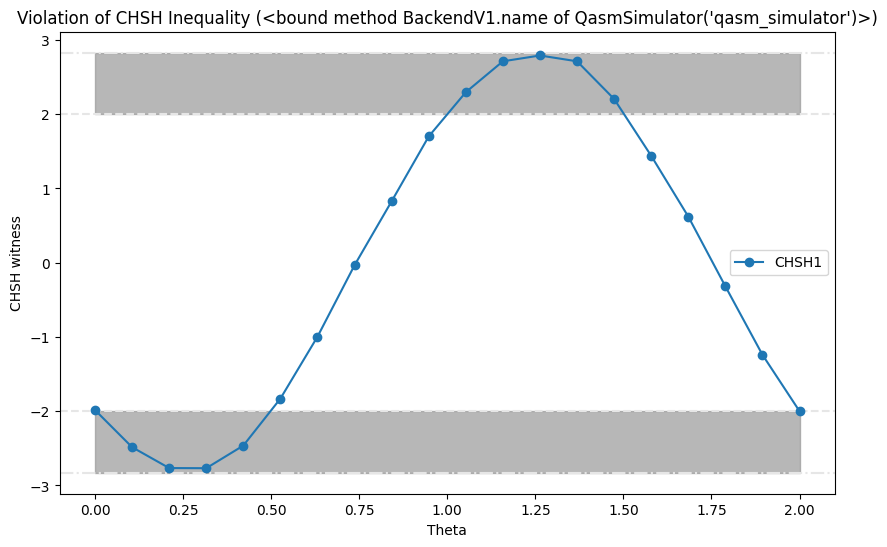

In [56]:
fig, ax = plt.subplots(figsize=(10, 6))
# results from hardware
ax.plot(phases / np.pi, Ss, "o-", label="CHSH1", zorder=3)
# classical bound +-2
ax.axhline(y=2, color="0.9", linestyle="--")
ax.axhline(y=-2, color="0.9", linestyle="--")
# quantum bound, +-2√2
ax.axhline(y=np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.axhline(y=-np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.fill_between(phases / np.pi, 2, 2 * np.sqrt(2), color="0.6", alpha=0.7)
ax.fill_between(phases / np.pi, -2, -2 * np.sqrt(2), color="0.6", alpha=0.7)


# set title, labels, and legend
plt.title(f"Violation of CHSH Inequality ({backend.name})")
plt.xlabel("Theta")
plt.ylabel("CHSH witness")
plt.legend();

# Real Device

In [89]:
service.backends()

[<IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibm_lagos')>,
 <IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('ibm_nairobi')>,
 <IBMBackend('ibm_perth')>]

In [90]:
# backend = service.backends(simulator=True)[0]
backend = service.backends(name='ibm_lagos')[0]
print(backend)

<IBMBackend('ibm_lagos')>


In [91]:
phases = np.linspace(0, 2*np.pi, 20)

with Session(service=service, backend=backend):
    sampler = Sampler(backend=backend)

    circuits = []

    for theta in phases:
        qc_XX = circuit('X', 'X', phase=theta)
        qc_XZ = circuit('X', 'Z', phase=theta)
        qc_ZX = circuit('Z', 'X', phase=theta)
        qc_ZZ = circuit('Z', 'Z', phase=theta)

        circuits += [qc_XX, qc_XZ, qc_ZX, qc_ZZ]

    job = sampler.run(circuits=circuits)

In [92]:
result = job.result()

In [93]:
Ss = []
for i, theta in enumerate(phases):
    counts_XX = result.quasi_dists[i*4]
    counts_XZ = result.quasi_dists[4*i+1]
    counts_ZX = result.quasi_dists[4*i+2]
    counts_ZZ = result.quasi_dists[4*i+3]

    probs_XX = count_to_prob(counts_XX, num_qubits=2)
    probs_XZ = count_to_prob(counts_XZ, num_qubits=2)
    probs_ZX = count_to_prob(counts_ZX, num_qubits=2)
    probs_ZZ = count_to_prob(counts_ZZ, num_qubits=2)


    eigenvalues = np.array([1, -1, -1, 1])
    expt_val_XX = np.dot(probs_XX, eigenvalues)
    expt_val_XZ = np.dot(probs_XZ, eigenvalues)
    expt_val_ZX = np.dot(probs_ZX, eigenvalues)
    expt_val_ZZ = np.dot(probs_ZZ, eigenvalues)

    S = expt_val_ZZ + expt_val_ZX + expt_val_XZ - expt_val_XX
    Ss.append(S)

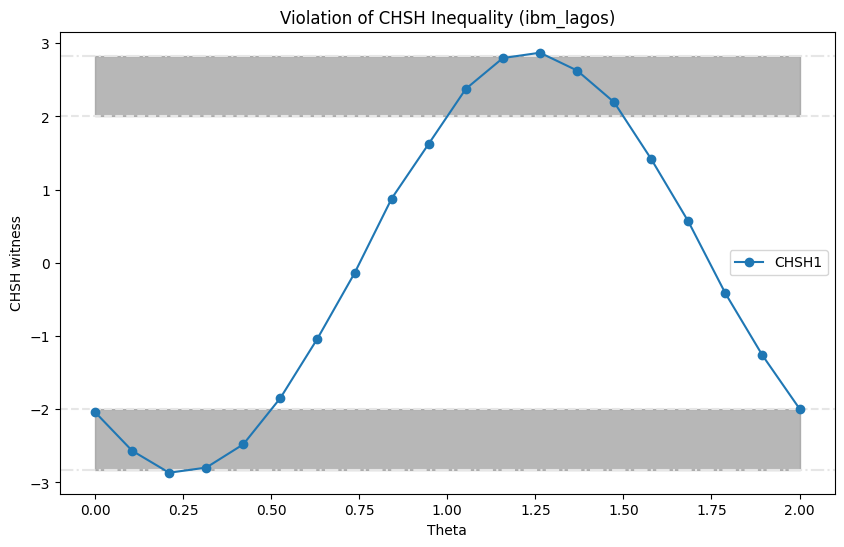

In [94]:
fig, ax = plt.subplots(figsize=(10, 6))
# results from hardware
ax.plot(phases / np.pi, Ss, "o-", label="CHSH1", zorder=3)
# classical bound +-2
ax.axhline(y=2, color="0.9", linestyle="--")
ax.axhline(y=-2, color="0.9", linestyle="--")
# quantum bound, +-2√2
ax.axhline(y=np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.axhline(y=-np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.fill_between(phases / np.pi, 2, 2 * np.sqrt(2), color="0.6", alpha=0.7)
ax.fill_between(phases / np.pi, -2, -2 * np.sqrt(2), color="0.6", alpha=0.7)


# set title, labels, and legend
plt.title(f"Violation of CHSH Inequality ({backend.name})")
plt.xlabel("Theta")
plt.ylabel("CHSH witness")
plt.legend();